In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m"  # Thư mục gốc
data_cut_dir = r"D:\pantio_m_cut"  # Thư mục lưu ảnh đã cắt

# Hàm tạo thư mục nếu chưa có
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Hàm đọc thông tin từ file XML và cắt ảnh
def crop_image_from_xml(xml_file, output_dir):
    # Đọc XML và lấy thông tin
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Lấy đường dẫn ảnh từ XML
    img_path = root.find('path')
    if img_path is None:
        print(f"Missing <path> in {xml_file}")
        return  # Nếu không có thẻ <path>, bỏ qua file này

    img_path = img_path.text

    # Kiểm tra xem ảnh có tồn tại không
    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        return  # Nếu ảnh không tồn tại, bỏ qua file này

    img = Image.open(img_path)

    # Kiểm tra và lấy thông tin bounding box từ XML
    object_node = root.find('object')
    if object_node is not None:
        bndbox = object_node.find('bndbox')
        if bndbox is not None:
            # Kiểm tra sự tồn tại của các thẻ xmin, ymin, xmax, ymax
            xmin = bndbox.find('xmin')
            ymin = bndbox.find('ymin')
            xmax = bndbox.find('xmax')
            ymax = bndbox.find('ymax')
            
            # Nếu tất cả các giá trị bounding box đều có, thực hiện cắt ảnh
            if xmin is not None and ymin is not None and xmax is not None and ymax is not None:
                try:
                    xmin = int(xmin.text)
                    ymin = int(ymin.text)
                    xmax = int(xmax.text)
                    ymax = int(ymax.text)
                except (ValueError, TypeError) as e:
                    # print(f"Error parsing bounding box in {xml_file}: {e}")
                    return  # Nếu có lỗi trong việc lấy thông tin bbox, bỏ qua file này
            else:
                # print(f"Bounding box information missing in {xml_file}")
                return  # Nếu không có thông tin bounding box đầy đủ, bỏ qua file này
        else:
            # print(f"No bndbox found in {xml_file}")
            return  # Nếu không có thẻ bndbox, bỏ qua file này
    else:
        # print(f"No object found in {xml_file}")
        return  # Nếu không có thẻ object, bỏ qua file này

    # Cắt ảnh theo bounding box
    cropped_img = img.crop((xmin, ymin, xmax, ymax))

    # Tạo thư mục đích nếu chưa có
    create_dir(output_dir)

    # Lưu ảnh đã cắt vào thư mục đích
    img_name = os.path.basename(img_path)
    cropped_img.save(os.path.join(output_dir, img_name))

# Hàm xử lý từng file XML
def process_single_file(xml_file, input_folder, output_folder):
    # Tạo thư mục đầu ra tương ứng trong data_cut, giữ nguyên cấu trúc thư mục con (bao gồm class)
    class_name = os.path.basename(os.path.dirname(xml_file))  # Lấy tên lớp từ thư mục chứa XML
    output_subdir = os.path.join(output_folder, class_name)  # Tạo thư mục con tương ứng trong data_cut
    
    # Thực hiện cắt ảnh
    crop_image_from_xml(xml_file, output_subdir)

# Hàm xử lý ảnh trong một thư mục
def process_images_in_folder(input_folder, output_folder):
    # Duyệt qua tất cả các thư mục con và tìm tất cả file XML
    files = []
    for subdir, dirs, filenames in os.walk(input_folder):  # Duyệt qua tất cả thư mục con
        for file in filenames:
            if file.endswith('.xml'):
                files.append(os.path.join(subdir, file))

    print(f"Found {len(files)} XML files in {input_folder}")

    # Duyệt qua các file XML và xử lý từng file
    with ThreadPoolExecutor() as executor:
        # Sử dụng multithreading để xử lý các file XML
        for xml_file in tqdm(files, desc=f'Processing folder {input_folder}', ncols=100):
            # Tạo thread cho mỗi file XML
            executor.submit(process_single_file, xml_file, input_folder, output_folder)

# Hàm chính để xử lý tất cả các lớp
def main():
    # Duyệt qua các thư mục 'train' và 'test'
    for dataset_type in ['train', 'test']:
        input_folder = os.path.join(data_dir, dataset_type)
        output_folder = os.path.join(data_cut_dir, dataset_type)
        
        # Xử lý tất cả ảnh trong thư mục train và test
        print(f"\nProcessing {dataset_type} dataset...")
        process_images_in_folder(input_folder, output_folder)
    
    print("\nHoàn thành cắt ảnh và lưu vào thư mục data_cut.")

if __name__ == "__main__":
    main()



Processing train dataset...
Found 7189 XML files in D:\pantio_m\train


Processing folder D:\pantio_m\train: 100%|███████████████████| 7189/7189 [00:00<00:00, 56246.09it/s]



Processing test dataset...
Found 4672 XML files in D:\pantio_m\test


Processing folder D:\pantio_m\test: 100%|████████████████████| 4672/4672 [00:00<00:00, 33131.16it/s]



Hoàn thành cắt ảnh và lưu vào thư mục data_cut.


In [3]:
import os
import pandas as pd

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m"  # Thư mục gốc

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_class(dataset_type):
    class_counts = {}  # Lưu trữ số lượng ảnh cho mỗi lớp
    dataset_folder = os.path.join(data_dir, dataset_type)

    # Duyệt qua các thư mục con (lớp) trong thư mục 'train' hoặc 'test'
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)
        
        if os.path.isdir(class_folder):  # Nếu là thư mục con (lớp)
            # Đếm số lượng ảnh (.jpg, .jpeg, .png)
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Đếm số lượng ảnh trong thư mục lớp
            class_counts[class_name] = len(image_files)

    return class_counts

# Hàm in số lượng ảnh dưới dạng bảng
def print_image_counts():
    data = {}

    # Duyệt qua các thư mục 'train' và 'test'
    for dataset_type in ['train', 'test']:
        print(f"Counting images in {dataset_type} dataset...")
        class_counts = count_images_in_class(dataset_type)
        
        # Gán kết quả vào bảng
        for class_name, count in class_counts.items():
            if class_name not in data:
                data[class_name] = {}
            data[class_name][dataset_type] = count

    # Chuyển đổi dictionary thành DataFrame của pandas
    df = pd.DataFrame.from_dict(data, orient='index').fillna(0).astype(int)

    # In bảng kết quả
    print("\nClass counts in train and test datasets:")
    print(df)

# Hàm chính
def main():
    print_image_counts()

if __name__ == "__main__":
    main()


Counting images in train dataset...
Counting images in test dataset...

Class counts in train and test datasets:
                   train  test
ao_2_day             355   277
ao_ba_lo             353   148
ao_da                165   123
ao_dai               617   499
ao_khoac_the_thao    503   500
ao_len              1108   996
ao_mangto            289   400
ao_so_mi            1085   367
ao_thun             1682   590
ao_tre_vai           288   136
ao_vest             1176   386
chan_vay_dai         766   327
chan_vay_ngan       1066   365
dam_maxi             383   580
dam_om               309   259
do_ngu_do_mac_nha    698   546
quan_dai             604   491
quan_jean            753   674
quan_short           899   518


In [4]:
import os
import pandas as pd

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m_cut"  # Thư mục gốc

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_class(dataset_type):
    class_counts = {}  # Lưu trữ số lượng ảnh cho mỗi lớp
    dataset_folder = os.path.join(data_dir, dataset_type)

    # Duyệt qua các thư mục con (lớp) trong thư mục 'train' hoặc 'test'
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)
        
        if os.path.isdir(class_folder):  # Nếu là thư mục con (lớp)
            # Đếm số lượng ảnh (.jpg, .jpeg, .png)
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Đếm số lượng ảnh trong thư mục lớp
            class_counts[class_name] = len(image_files)

    return class_counts

# Hàm in số lượng ảnh dưới dạng bảng
def print_image_counts():
    data = {}

    # Duyệt qua các thư mục 'train' và 'test'
    for dataset_type in ['train', 'test']:
        print(f"Counting images in {dataset_type} dataset...")
        class_counts = count_images_in_class(dataset_type)
        
        # Gán kết quả vào bảng
        for class_name, count in class_counts.items():
            if class_name not in data:
                data[class_name] = {}
            data[class_name][dataset_type] = count

    # Chuyển đổi dictionary thành DataFrame của pandas
    df = pd.DataFrame.from_dict(data, orient='index').fillna(0).astype(int)

    # In bảng kết quả
    print("\nClass counts in train and test datasets:")
    print(df)

# Hàm chính
def main():
    print_image_counts()

if __name__ == "__main__":
    main()


Counting images in train dataset...
Counting images in test dataset...

Class counts in train and test datasets:
                   train  test
ao_2_day             210   135
ao_ba_lo             154    90
ao_da                141   101
ao_dai               448   255
ao_khoac_the_thao    296   234
ao_len               508   628
ao_mangto            224   303
ao_so_mi             543   221
ao_thun              617   254
ao_tre_vai           136    75
ao_vest              626   205
chan_vay_dai         519   218
chan_vay_ngan        712   267
dam_maxi             230   308
dam_om               213   192
do_ngu_do_mac_nha    413   225
quan_dai             180   198
quan_jean            401   410
quan_short           210   170


Counting images in train dataset...
Counting images in test dataset...

Class counts in train and test datasets:
                   train  test
ao_2_day             210   135
ao_ba_lo             154    90
ao_da                141   101
ao_dai               448   255
ao_khoac_the_thao    296   234
ao_len               508   628
ao_mangto            224   303
ao_so_mi             543   221
ao_thun              617   254
ao_tre_vai           136    75
ao_vest              626   205
chan_vay_dai         519   218
chan_vay_ngan        712   267
dam_maxi             230   308
dam_om               213   192
do_ngu_do_mac_nha    413   225
quan_dai             180   198
quan_jean            401   410
quan_short           210   170


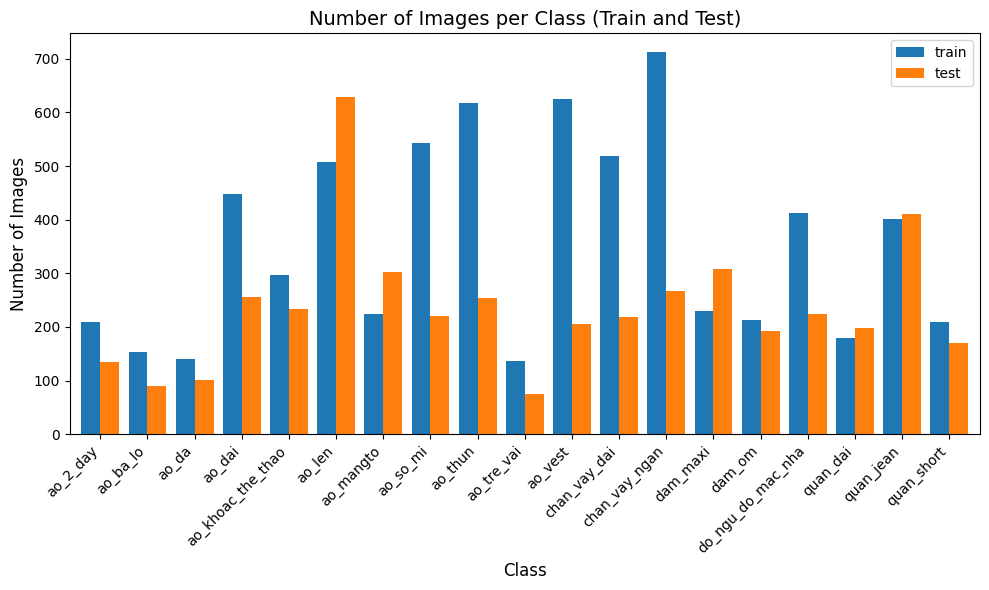

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m_cut"  # Thư mục gốc

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_class(dataset_type):
    class_counts = {}  # Lưu trữ số lượng ảnh cho mỗi lớp
    dataset_folder = os.path.join(data_dir, dataset_type)

    # Duyệt qua các thư mục con (lớp) trong thư mục 'train' hoặc 'test'
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)
        
        if os.path.isdir(class_folder):  # Nếu là thư mục con (lớp)
            # Đếm số lượng ảnh (.jpg, .jpeg, .png)
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Đếm số lượng ảnh trong thư mục lớp
            class_counts[class_name] = len(image_files)

    return class_counts

# Hàm in số lượng ảnh dưới dạng bảng và biểu đồ
def print_and_plot_image_counts():
    data = {}

    # Duyệt qua các thư mục 'train' và 'test'
    for dataset_type in ['train', 'test']:
        print(f"Counting images in {dataset_type} dataset...")
        class_counts = count_images_in_class(dataset_type)
        
        # Gán kết quả vào bảng
        for class_name, count in class_counts.items():
            if class_name not in data:
                data[class_name] = {}
            data[class_name][dataset_type] = count

    # Chuyển đổi dictionary thành DataFrame của pandas
    df = pd.DataFrame.from_dict(data, orient='index').fillna(0).astype(int)

    # In bảng kết quả
    print("\nClass counts in train and test datasets:")
    print(df)

    # Vẽ biểu đồ cột
    df.plot(kind='bar', figsize=(10, 6), width=0.8)

    # Thiết lập tiêu đề và nhãn cho biểu đồ
    plt.title('Number of Images per Class (Train and Test)', fontsize=14)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    
    # Hiển thị biểu đồ
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Hàm chính
def main():
    print_and_plot_image_counts()

if __name__ == "__main__":
    main()


In [6]:
import os
import shutil

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m_cut"  # Thư mục gốc

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_class(dataset_type):
    class_counts = {}  # Lưu trữ số lượng ảnh cho mỗi lớp
    dataset_folder = os.path.join(data_dir, dataset_type)

    # Duyệt qua các thư mục con (lớp) trong thư mục 'train' hoặc 'test'
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)
        
        if os.path.isdir(class_folder):  # Nếu là thư mục con (lớp)
            # Đếm số lượng ảnh (.jpg, .jpeg, .png)
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Đếm số lượng ảnh trong thư mục lớp
            class_counts[class_name] = len(image_files)

    return class_counts

# Hàm đổi tập train và test cho những lớp có số lượng ảnh trong test > train
def swap_train_test_for_classes():
    # Đếm số lượng ảnh cho mỗi lớp trong train và test
    train_counts = count_images_in_class('train')
    test_counts = count_images_in_class('test')

    # Duyệt qua các lớp để kiểm tra và hoán đổi nếu cần
    for class_name in train_counts:
        train_count = train_counts[class_name]
        test_count = test_counts.get(class_name, 0)  # Nếu lớp không có trong test, test_count = 0

        if test_count > train_count:
            print(f"Swapping train and test for class '{class_name}' because test has more images.")
            
            # Đổi tên các thư mục và di chuyển ảnh
            train_folder = os.path.join(data_dir, 'train', class_name)
            test_folder = os.path.join(data_dir, 'test', class_name)
            
            # Tạo thư mục tạm thời để hoán đổi
            temp_folder = os.path.join(data_dir, 'temp_swap_folder')
            os.makedirs(temp_folder, exist_ok=True)
            
            # Di chuyển ảnh và XML từ train sang test
            shutil.move(train_folder, os.path.join(temp_folder, 'train'))
            shutil.move(test_folder, train_folder)
            
            # Di chuyển ảnh và XML từ test sang train
            shutil.move(os.path.join(temp_folder, 'train'), test_folder)
            
            # Xóa thư mục tạm thời
            shutil.rmtree(temp_folder)
            
            print(f"Successfully swapped '{class_name}'.")

# Hàm chính
def main():
    # Thực hiện hoán đổi
    print("Checking and swapping train and test sets for classes...")
    swap_train_test_for_classes()
    print("\nCompleted swapping train and test sets for relevant classes.")

if __name__ == "__main__":
    main()


Checking and swapping train and test sets for classes...
Swapping train and test for class 'ao_len' because test has more images.
Successfully swapped 'ao_len'.
Swapping train and test for class 'ao_mangto' because test has more images.
Successfully swapped 'ao_mangto'.
Swapping train and test for class 'dam_maxi' because test has more images.
Successfully swapped 'dam_maxi'.
Swapping train and test for class 'quan_dai' because test has more images.
Successfully swapped 'quan_dai'.
Swapping train and test for class 'quan_jean' because test has more images.
Successfully swapped 'quan_jean'.

Completed swapping train and test sets for relevant classes.


Counting images in train dataset...
Counting images in test dataset...

Class counts in train and test datasets:
                   train  test
ao_2_day             210   135
ao_ba_lo             154    90
ao_da                141   101
ao_dai               448   255
ao_khoac_the_thao    296   234
ao_len               628   508
ao_mangto            303   224
ao_so_mi             543   221
ao_thun              617   254
ao_tre_vai           136    75
ao_vest              626   205
chan_vay_dai         519   218
chan_vay_ngan        712   267
dam_maxi             308   230
dam_om               213   192
do_ngu_do_mac_nha    413   225
quan_dai             198   180
quan_jean            410   401
quan_short           210   170


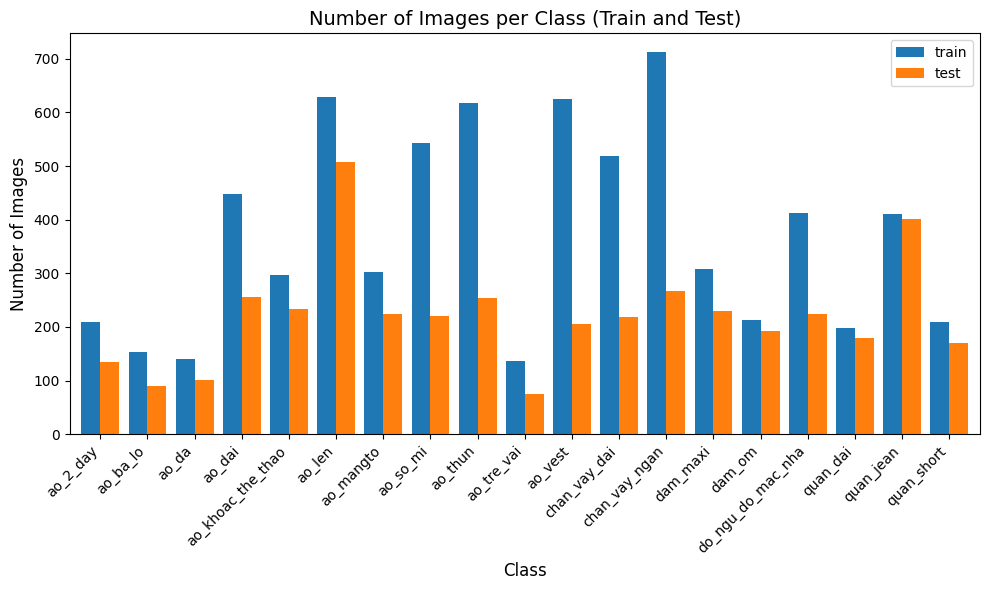

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m_cut"  # Thư mục gốc

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_class(dataset_type):
    class_counts = {}  # Lưu trữ số lượng ảnh cho mỗi lớp
    dataset_folder = os.path.join(data_dir, dataset_type)

    # Duyệt qua các thư mục con (lớp) trong thư mục 'train' hoặc 'test'
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)
        
        if os.path.isdir(class_folder):  # Nếu là thư mục con (lớp)
            # Đếm số lượng ảnh (.jpg, .jpeg, .png)
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Đếm số lượng ảnh trong thư mục lớp
            class_counts[class_name] = len(image_files)

    return class_counts

# Hàm in số lượng ảnh dưới dạng bảng và biểu đồ
def print_and_plot_image_counts():
    data = {}

    # Duyệt qua các thư mục 'train' và 'test'
    for dataset_type in ['train', 'test']:
        print(f"Counting images in {dataset_type} dataset...")
        class_counts = count_images_in_class(dataset_type)
        
        # Gán kết quả vào bảng
        for class_name, count in class_counts.items():
            if class_name not in data:
                data[class_name] = {}
            data[class_name][dataset_type] = count

    # Chuyển đổi dictionary thành DataFrame của pandas
    df = pd.DataFrame.from_dict(data, orient='index').fillna(0).astype(int)

    # In bảng kết quả
    print("\nClass counts in train and test datasets:")
    print(df)

    # Vẽ biểu đồ cột
    df.plot(kind='bar', figsize=(10, 6), width=0.8)

    # Thiết lập tiêu đề và nhãn cho biểu đồ
    plt.title('Number of Images per Class (Train and Test)', fontsize=14)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    
    # Hiển thị biểu đồ
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Hàm chính
def main():
    print_and_plot_image_counts()

if __name__ == "__main__":
    main()


In [8]:
import os
import numpy as np

def count_images_in_classes(root_dir):
    class_counts = {}
    
    # Traverse through all directories (classes)
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        
        # Only consider directories (classes)
        if os.path.isdir(class_path):
            # Count number of images in the class directory
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])  # Adjust extensions as necessary
            class_counts[class_name] = num_images
            
    return class_counts

def calculate_class_weights(class_counts, total_images):
    # Calculate the weights as the inverse of class frequency
    weights = {}
    for class_name, count in class_counts.items():
        weights[class_name] = total_images / count
    
    # Normalize the weights to sum to 1 (optional, you can skip this if you want raw weights)
    total_weight = sum(weights.values())
    normalized_weights = {class_name: weight / total_weight for class_name, weight in weights.items()}
    
    return normalized_weights

# Set the directory to your `pantio_m_cut/train`
train_dir = "D:/pantio_m_cut/train"

# Get class counts for training images
train_class_counts = count_images_in_classes(train_dir)

# Calculate the total number of images in the entire dataset
total_train_images = sum(train_class_counts.values())

# Calculate class weights
class_weights = calculate_class_weights(train_class_counts, total_train_images)

# Print the class weights
print("Class Weights for Training Dataset:")
for class_name, weight in class_weights.items():
    print(f"{class_name}: {weight:.4f}")


Class Weights for Training Dataset:
ao_2_day: 0.0709
ao_ba_lo: 0.0966
ao_da: 0.1055
ao_dai: 0.0332
ao_khoac_the_thao: 0.0503
ao_len: 0.0237
ao_mangto: 0.0491
ao_so_mi: 0.0274
ao_thun: 0.0241
ao_tre_vai: 0.1094
ao_vest: 0.0238
chan_vay_dai: 0.0287
chan_vay_ngan: 0.0209
dam_maxi: 0.0483
dam_om: 0.0699
do_ngu_do_mac_nha: 0.0360
quan_dai: 0.0751
quan_jean: 0.0363
quan_short: 0.0709


In [9]:
import os
import shutil
import random
import concurrent.futures

# Define source and destination directories for the training and validation datasets
src_train_dir = r'D:\pantio_m_cut\train'
dst_train_dir = r'D:\pantio_m_cut_under\train'
src_val_dir = r'D:\pantio_m_cut\test'
dst_val_dir = r'D:\pantio_m_cut_under\test'

# Function to create class folder structure in destination directory
def create_dir_structure(src_dir, dst_dir):
    """
    Creates the directory structure in the destination directory based on the source directory.
    """
    for root, dirs, files in os.walk(src_dir):
        for dir_name in dirs:
            class_folder_path = os.path.join(dst_dir, os.path.relpath(os.path.join(root, dir_name), src_dir))
            if not os.path.exists(class_folder_path):
                os.makedirs(class_folder_path)

# Function to copy an image from source to destination
def copy_image(src_image_path, dst_image_path):
    """
    Copy a single image from source to destination.
    This function is used in multithreading to copy images concurrently.
    """
    shutil.copy(src_image_path, dst_image_path)

# Function to undersample a class folder (i.e., reduce number of images to the minority class size)
def undersample_class(class_folder_path, min_samples, dst_class_folder_path):
    """
    Undersample the class folder to the minimum number of samples and save to the destination folder.
    """
    images = os.listdir(class_folder_path)
    # If there are more samples than the minimum, perform undersampling
    if len(images) > min_samples:
        # Randomly sample the images
        images = random.sample(images, min_samples)
    
    # Use multithreading to copy the images concurrently
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for image_name in images:
            src_image_path = os.path.join(class_folder_path, image_name)
            dst_image_path = os.path.join(dst_class_folder_path, image_name)
            futures.append(executor.submit(copy_image, src_image_path, dst_image_path))
        
        # Wait for all threads to complete
        for future in futures:
            future.result()

# Function to count the number of images in each class in the dataset
def count_images_in_classes(dataset_dir):
    """
    Count the number of images in each class folder within the dataset.
    """
    class_counts = {}
    for class_folder in os.listdir(dataset_dir):
        class_folder_path = os.path.join(dataset_dir, class_folder)
        if os.path.isdir(class_folder_path):
            class_counts[class_folder] = len(os.listdir(class_folder_path))
    return class_counts

# Function to undersample both the train and test datasets
def undersample_dataset(src_dir, dst_dir):
    """
    Undersample both the train and test dataset to balance the number of images in each class.
    """
    # Step 1: Get the class counts from the dataset
    class_counts = count_images_in_classes(src_dir)
    
    # Step 2: Find the minimum class size (for undersampling)
    min_class_size = min(class_counts.values())
    print(f"Minority class size: {min_class_size}")
    
    # Step 3: Create the directory structure in the destination
    create_dir_structure(src_dir, dst_dir)
    
    # Step 4: Undersample each class and copy the images
    for class_folder in os.listdir(src_dir):
        class_folder_path = os.path.join(src_dir, class_folder)
        if os.path.isdir(class_folder_path):
            dst_class_folder_path = os.path.join(dst_dir, class_folder)
            undersample_class(class_folder_path, min_class_size, dst_class_folder_path)

# Function to undersample the training dataset
def undersample_training_dataset():
    """
    Perform undersampling of the training dataset and save it to a new directory structure.
    """
    print(f"Undersampling the training dataset from {src_train_dir} to {dst_train_dir}")
    undersample_dataset(src_train_dir, dst_train_dir)

# Function to undersample the validation dataset
def undersample_validation_dataset():
    """
    Perform undersampling of the validation dataset and save it to a new directory structure.
    """
    print(f"Undersampling the validation dataset from {src_val_dir} to {dst_val_dir}")
    undersample_dataset(src_val_dir, dst_val_dir)

# Run the undersampling process for both training and validation datasets
undersample_training_dataset()
undersample_validation_dataset()



Undersampling the training dataset from D:\pantio_m_cut\train to D:\pantio_m_cut_under\train
Minority class size: 136
Undersampling the validation dataset from D:\pantio_m_cut\test to D:\pantio_m_cut_under\test
Minority class size: 75


Counting images in train dataset...
Counting images in test dataset...

Class counts in train and test datasets:
                   train  test
ao_2_day             136    75
ao_ba_lo             136    75
ao_da                136    75
ao_dai               136    75
ao_khoac_the_thao    136    75
ao_len               136    75
ao_mangto            136    75
ao_so_mi             136    75
ao_thun              136    75
ao_tre_vai           136    75
ao_vest              136    75
chan_vay_dai         136    75
chan_vay_ngan        136    75
dam_maxi             136    75
dam_om               136    75
do_ngu_do_mac_nha    136    75
quan_dai             136    75
quan_jean            136    75
quan_short           136    75


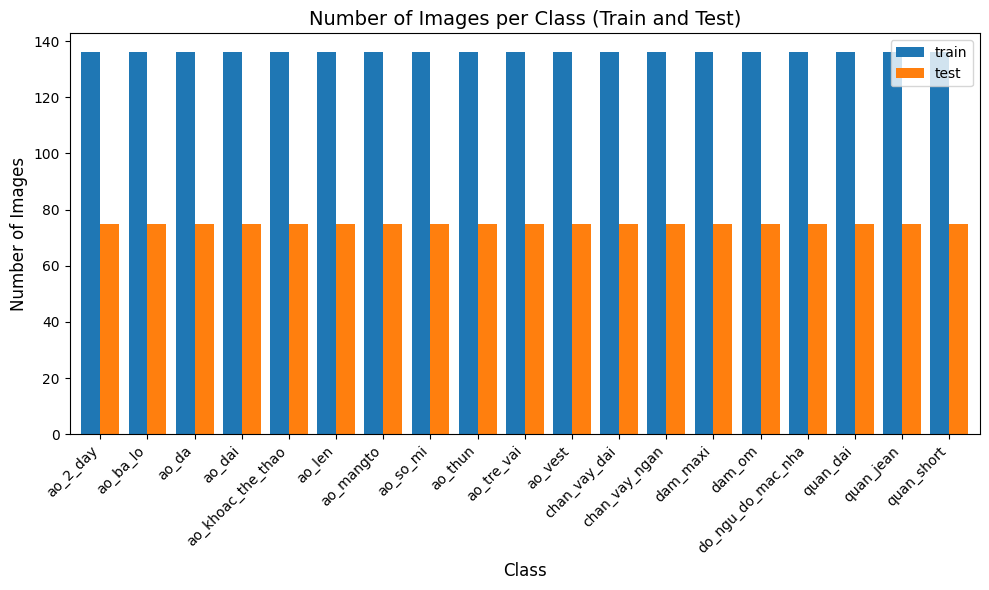

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Định nghĩa các thư mục
data_dir = r"D:\pantio_m_cut_under"  # Thư mục gốc

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_class(dataset_type):
    class_counts = {}  # Lưu trữ số lượng ảnh cho mỗi lớp
    dataset_folder = os.path.join(data_dir, dataset_type)

    # Duyệt qua các thư mục con (lớp) trong thư mục 'train' hoặc 'test'
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)
        
        if os.path.isdir(class_folder):  # Nếu là thư mục con (lớp)
            # Đếm số lượng ảnh (.jpg, .jpeg, .png)
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.webp'))]
            
            # Đếm số lượng ảnh trong thư mục lớp
            class_counts[class_name] = len(image_files)

    return class_counts

# Hàm in số lượng ảnh dưới dạng bảng và biểu đồ
def print_and_plot_image_counts():
    data = {}

    # Duyệt qua các thư mục 'train' và 'test'
    for dataset_type in ['train', 'test']:
        print(f"Counting images in {dataset_type} dataset...")
        class_counts = count_images_in_class(dataset_type)
        
        # Gán kết quả vào bảng
        for class_name, count in class_counts.items():
            if class_name not in data:
                data[class_name] = {}
            data[class_name][dataset_type] = count

    # Chuyển đổi dictionary thành DataFrame của pandas
    df = pd.DataFrame.from_dict(data, orient='index').fillna(0).astype(int)

    # In bảng kết quả
    print("\nClass counts in train and test datasets:")
    print(df)

    # Vẽ biểu đồ cột
    df.plot(kind='bar', figsize=(10, 6), width=0.8)

    # Thiết lập tiêu đề và nhãn cho biểu đồ
    plt.title('Number of Images per Class (Train and Test)', fontsize=14)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    
    # Hiển thị biểu đồ
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Hàm chính
def main():
    print_and_plot_image_counts()

if __name__ == "__main__":
    main()


In [13]:
import os
import numpy as np

def count_images_in_classes(root_dir):
    class_counts = {}
    
    # Traverse through all directories (classes)
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        
        # Only consider directories (classes)
        if os.path.isdir(class_path):
            # Count number of images in the class directory
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])  # Adjust extensions as necessary
            class_counts[class_name] = num_images
            
    return class_counts

def calculate_class_weights(class_counts, total_images):
    # Calculate the weights as the inverse of class frequency
    weights = {}
    for class_name, count in class_counts.items():
        weights[class_name] = total_images / count
    
    # Normalize the weights to sum to 1 (optional, you can skip this if you want raw weights)
    total_weight = sum(weights.values())
    normalized_weights = {class_name: weight / total_weight for class_name, weight in weights.items()}
    
    return normalized_weights

# Set the directory to your `pantio_m_cut/train`
train_dir = "D:/pantio_m_cut_under/train"

# Get class counts for training images
train_class_counts = count_images_in_classes(train_dir)

# Calculate the total number of images in the entire dataset
total_train_images = sum(train_class_counts.values())

# Calculate class weights
class_weights = calculate_class_weights(train_class_counts, total_train_images)

# Print the class weights
print("Class Weights for Training Dataset:")
for class_name, weight in class_weights.items():
    print(f"{class_name}: {weight:.4f}")


Class Weights for Training Dataset:
ao_2_day: 0.0526
ao_ba_lo: 0.0526
ao_da: 0.0526
ao_dai: 0.0526
ao_khoac_the_thao: 0.0526
ao_len: 0.0526
ao_mangto: 0.0526
ao_so_mi: 0.0526
ao_thun: 0.0526
ao_tre_vai: 0.0526
ao_vest: 0.0526
chan_vay_dai: 0.0526
chan_vay_ngan: 0.0526
dam_maxi: 0.0526
dam_om: 0.0526
do_ngu_do_mac_nha: 0.0526
quan_dai: 0.0526
quan_jean: 0.0526
quan_short: 0.0526
